# Data

In [12]:
import pickle

file = '/deep2/u/yma42/StableDiffusionProject/label_imbalance/data/cifar-10-batches-py/data_batch_1'

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batch1 = unpickle(file)

In [13]:
batch1[b'data'][0]

array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)

In [1]:
import pickle
from pathlib import Path

import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms 


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def parse_cifar_data (root_dir: str):
    root_dir = Path(root_dir)
    labels = []
    data = []
    for batch in root_dir.glob('data_batch_*'):
        raw_batch = unpickle(str(batch))
        labels.append(raw_batch[b'labels'])
        data.append(raw_batch[b'data'])
    train_labels = np.concatenate(labels)
    train_data = np.concatenate(data)
    train_data = train_data.reshape(len(train_data), 3, 32, 32).transpose(0,2,3,1)

    raw_batch = unpickle(str(root_dir/'test_batch'))
    test_labels = np.array(raw_batch[b'labels'])
    test_data = raw_batch[b'data']
    test_data = test_data.reshape(len(test_data), 3, 32, 32).transpose(0,2,3,1)

    meta_data = unpickle(str(root_dir/'batches.meta'))
    label_mapping = {class_name.decode('utf-8'): i for i, class_name in enumerate(meta_data[b'label_names'])}
    index_mapping = {i: class_name.decode('utf-8') for i, class_name in enumerate(meta_data[b'label_names'])}

    return train_data, train_labels, test_data, test_labels, label_mapping, index_mapping


class CIFAR10FullDataset(Dataset):
    MEAN = (0.49139968, 0.48215827, 0.44653124)
    STD = (0.24703233, 0.24348505, 0.26158768)
    def __init__(self, base_path: str = None, is_train: bool = True, standardize: bool = True ):
        if base_path is None:
            base_path = '/deep2/u/yma42/StableDiffusionProject/label_imbalance/data/cifar-10-batches-py'
        
        train_data, train_labels, test_data, test_labels, self.label_mapping, self.index_mapping = parse_cifar_data(base_path)

        if is_train:
            self.data = train_data
            self.labels = train_labels
        else:
            self.data = test_data
            self.labels = test_labels

        t = []
        t.append(transforms.ToTensor())

        if standardize:
            t.append(transforms.Normalize(mean=self.MEAN, std=self.STD))

        self.preprocessing = transforms.Compose(t)


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        x = self.preprocessing(x)
        return x, y


class CIFAR10ImbalanceDataset (CIFAR10FullDataset):
    def __init__(self, base_path: str = None, is_train: bool = True, standardize: bool = True, 
                       target_cls: int = 0, remove_ratio: float = 0.99):
        super().__init__(base_path, is_train, standardize)
        assert is_train, f'You should only use this dataset for trinaing'

        self.target_cls = target_cls
        # find all class idx
        cls_idx = np.where(self.labels==target_cls)[0]
        num_per_cls = len(cls_idx)
        num_to_remove = int(num_per_cls * remove_ratio) 
        # randomly pick sample to removec
        idx = np.random.choice(num_per_cls, num_to_remove, replace=False)
        idx_to_remove = cls_idx[idx] 
        subset_idx = np.ones(len(self.data), dtype=np.bool8)
        subset_idx[idx_to_remove] = False
        self.data = self.data[subset_idx]
        self.labels = self.labels[subset_idx]
        




In [17]:
root_dir = '/deep2/u/yma42/StableDiffusionProject/label_imbalance/data/cifar-10-batches-py'
dataset = CIFAR10FullDataset(root_dir, standardize=False)

In [86]:
root_dir = '/deep2/u/yma42/StableDiffusionProject/label_imbalance/data/cifar-10-batches-py'
train_data, train_labels, test_data, test_labels, label_mapping, index_mapping = parse_cifar_data(root_dir)

In [94]:
target = 2
cls_idx = np.where(train_labels==target)[0]
num_per_cls = len(cls_idx)
num_to_remove = int(num_per_cls * 0.99) 
idx = np.random.choice(num_per_cls, num_to_remove, replace=False)
idx_to_remove = cls_idx[idx] 
subset_idx = np.ones(len(train_data), dtype=np.bool8)
subset_idx[idx_to_remove] = False
data = train_data[subset_idx]
label = train_labels[subset_idx]

(array([5000., 5000.,   50., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

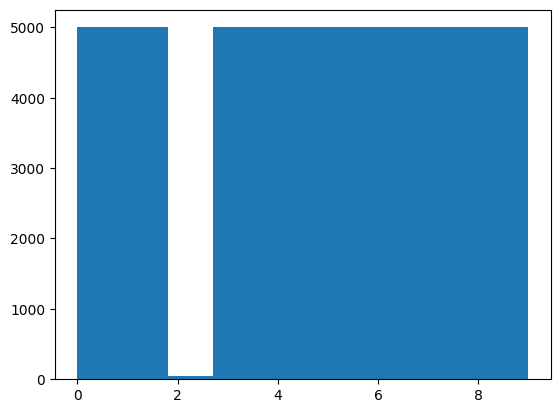

In [97]:
import matplotlib.pyplot as plt 

plt.hist(label)

(-0.5, 31.5, 31.5, -0.5)

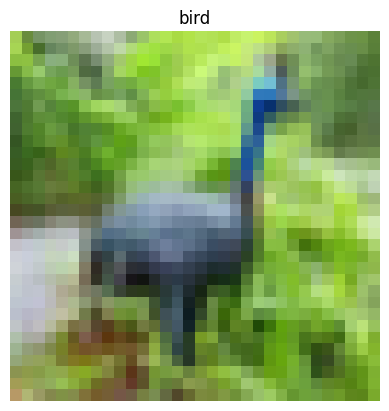

In [50]:
import matplotlib.pyplot as plt 
idx = np.random.choice(50000, 1)
x, y = dataset[idx[0]]
plt.imshow(x.permute(1, 2, 0))
plt.title(dataset.index_mapping[y])
plt.axis('off')

In [44]:
x.permute

array([False, False, False, ..., False, False, False])

# Model

In [105]:
import timm

def create_model (cfg): 
    model = timm.create_model('resnet50', num_classes=10)
    return model

In [104]:
from torchinfo import summary

summary(model, (4096, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [4096, 10]                --
├─Conv2d: 1-1                            [4096, 64, 16, 16]        9,408
├─BatchNorm2d: 1-2                       [4096, 64, 16, 16]        128
├─ReLU: 1-3                              [4096, 64, 16, 16]        --
├─MaxPool2d: 1-4                         [4096, 64, 8, 8]          --
├─Sequential: 1-5                        [4096, 256, 8, 8]         --
│    └─Bottleneck: 2-1                   [4096, 256, 8, 8]         --
│    │    └─Conv2d: 3-1                  [4096, 64, 8, 8]          4,096
│    │    └─BatchNorm2d: 3-2             [4096, 64, 8, 8]          128
│    │    └─ReLU: 3-3                    [4096, 64, 8, 8]          --
│    │    └─Conv2d: 3-4                  [4096, 64, 8, 8]          36,864
│    │    └─BatchNorm2d: 3-5             [4096, 64, 8, 8]          128
│    │    └─Identity: 3-6                [4096, 64, 8, 8]          --
│ 

In [1]:

from .dataset import CIFAR10FullDataset, CIFAR10ImbalanceDataset

globals()

ImportError: attempted relative import with no known parent package

In [2]:
from .lightning_task import Classification

ImportError: attempted relative import with no known parent package